# Simple Neural Network
This notebook is a simple neural network with PyTorch that classifies the MNIST dataset.

In [1]:
# if you want to run this code on GPU, please change the following line to True
WITH_GPU = True

## Load the dataset

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# load the training and test data
train_data = MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())
print("Train data size: ", len(train_data), "Test data size: ", len(test_data))

# create the data loader
img_size = 28
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Train data size:  60000 Test data size:  10000


## Build the model

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(img_size*img_size, 1024) # fully connected layer
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = x.view(-1, img_size*img_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
if WITH_GPU:
    net.cuda() # use GPU
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


## Train the model

In [4]:
from torch import optim

# define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

# log the loss of training and test data
record_loss_train = []
record_loss_test = []

# train the model
for epoch in range(10): # 10 epochs
    # train the model
    net.train()
    loss_train = 0
    for i, (x, t) in enumerate(train_loader): # get a batch of data
        if WITH_GPU:
            x, t = x.cuda(), t.cuda()
        optimizer.zero_grad() # clear the gradients
        y = net(x) # forward pass
        loss = loss_fn(y, t) # compute the loss
        loss_train += loss.item()
        loss.backward() # backpropagation
        optimizer.step() # update the parameters
    record_loss_train.append(loss_train/(i+1))
    
    # evaluate the model
    net.eval()
    loss_test = 0
    for i, (x, t) in enumerate(test_loader): # get a batch of data
        if WITH_GPU:
            x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fn(y, t)
        loss_test += loss.item()
    record_loss_test.append(loss_test/(i+1))

    if epoch % 1 == 0:
        print("Epoch: ", epoch, "Loss_train: ", loss_train/len(train_loader), "Loss_test: ", loss_test/len(test_loader))

Epoch:  0 Loss_train:  2.2177149295806884 Loss_test:  2.093573325872421
Epoch:  1 Loss_train:  1.830822445483918 Loss_test:  1.45168496966362
Epoch:  2 Loss_train:  1.125014612522531 Loss_test:  0.8366081401705742
Epoch:  3 Loss_train:  0.7242739335019538 Loss_test:  0.6000170931220055
Epoch:  4 Loss_train:  0.5625834913963967 Loss_test:  0.49214075729250906
Epoch:  5 Loss_train:  0.4819538234396184 Loss_test:  0.43258267976343634
Epoch:  6 Loss_train:  0.4346142409963811 Loss_test:  0.3956173876300454
Epoch:  7 Loss_train:  0.40316427895363344 Loss_test:  0.3703895887359977
Epoch:  8 Loss_train:  0.38023679725667264 Loss_test:  0.3516688165254891
Epoch:  9 Loss_train:  0.3632629771181878 Loss_test:  0.33737016916275026


## History

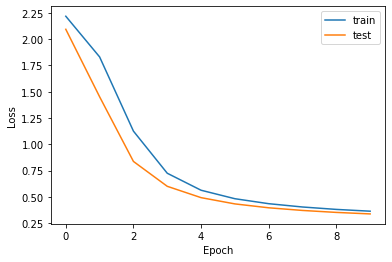

In [5]:
import matplotlib.pyplot as plt

# plot the loss curve
plt.plot(range(len(record_loss_train)) ,record_loss_train, label='train')
plt.plot(range(len(record_loss_test)) ,record_loss_test, label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Accuracy

In [6]:
# calculate the accuracy
net.eval()
correct = 0
total = 0
for i, (x, t) in enumerate(test_loader):
    if WITH_GPU:
        x, t = x.cuda(), t.cuda()
    x = x.view(-1, img_size*img_size)
    y = net(x)
    correct += (torch.argmax(y, dim=1) == t).sum().item()
    total += len(x)
print("Accuracy: ", correct/total*100, "%")

Accuracy:  90.29 %
